In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import copy
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples

In [11]:
# HELPER FUNCTIONS

"""
Encode categorical variables and fill missing values with 0
"""
def encode_and_fill(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)

    ordinal_encoder = OrdinalEncoder()
    label_df = df.copy()
    label_df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

    # Fill missing values
    label_df['energy_star_rating'] = label_df['energy_star_rating'].fillna(label_df['energy_star_rating'].mean())
    label_df['direction_max_wind_speed'] = label_df['direction_max_wind_speed'].fillna(1.0)
    label_df['direction_peak_wind_speed'] = label_df['direction_peak_wind_speed'].fillna(1.0)
    label_df['max_wind_speed'] = label_df['max_wind_speed'].fillna(1.0)
    label_df['days_with_fog'] = label_df['days_with_fog'].fillna(label_df['days_with_fog'].mean())
    label_df = label_df.fillna(0)

    return label_df

"""
Replace groups of highly correlated features with their average values
"""
def avg_features(df):
    Xtraindf = copy.deepcopy(df)
    Xtraindf['Avg_min_temp_winter'] = (Xtraindf['january_min_temp'] + Xtraindf['february_min_temp'] + Xtraindf['march_min_temp'] + Xtraindf['april_min_temp'] + Xtraindf['october_min_temp'] + Xtraindf['november_min_temp'] + Xtraindf['december_min_temp'])/7
    Xtraindf['Avg_max_temp_winter'] = (Xtraindf['january_max_temp'] + Xtraindf['february_max_temp'] + Xtraindf['march_max_temp'] + Xtraindf['april_max_temp'] + Xtraindf['october_max_temp'] + Xtraindf['november_max_temp'] + Xtraindf['december_max_temp'])/7
    Xtraindf['Avg_temp_winter'] = (Xtraindf['january_avg_temp'] + Xtraindf['february_avg_temp'] + Xtraindf['march_avg_temp'] + Xtraindf['april_avg_temp'] + Xtraindf['october_avg_temp'] + Xtraindf['november_avg_temp'] + Xtraindf['december_avg_temp'])/7
    Xtraindf['Avg_min_temp_summer'] = (Xtraindf['may_min_temp'] + Xtraindf['june_min_temp'] + Xtraindf['july_min_temp'] + Xtraindf['august_min_temp'] + Xtraindf['september_min_temp'])/5 
    Xtraindf['Avg_max_temp_summer'] = (Xtraindf['may_max_temp'] + Xtraindf['june_max_temp'] + Xtraindf['july_max_temp'] + Xtraindf['august_max_temp'] + Xtraindf['september_max_temp'])/5
    Xtraindf['Avg_temp_summer'] = (Xtraindf['may_avg_temp'] + Xtraindf['june_avg_temp'] + Xtraindf['july_avg_temp'] + Xtraindf['august_avg_temp'] + Xtraindf['september_avg_temp'])/5 
    Xtraindf['Avg_days_below30F'] = (Xtraindf['days_below_30F'] + Xtraindf['days_below_20F'] + Xtraindf['days_below_10F'] + Xtraindf['days_below_0F'])/4
    
    # Drop features
    rmv_features = ['january_min_temp','february_min_temp','march_min_temp','april_min_temp','october_min_temp','november_min_temp','december_min_temp']
    rmv_features += ['january_max_temp','february_max_temp','march_max_temp','april_max_temp','october_max_temp','november_max_temp','december_max_temp']
    rmv_features += ['january_avg_temp','february_avg_temp','march_avg_temp','april_avg_temp','october_avg_temp','november_avg_temp','december_avg_temp']
    rmv_features += ['may_min_temp','june_min_temp','july_min_temp','august_min_temp','september_min_temp']
    rmv_features += ['may_max_temp','june_max_temp','july_max_temp','august_max_temp','september_max_temp']
    rmv_features += ['may_avg_temp','june_avg_temp','july_avg_temp','august_avg_temp','september_avg_temp']
    rmv_features += ['days_below_30F','days_below_20F','days_below_10F','days_below_0F']
    Xtraindf = Xtraindf.drop(columns=rmv_features)
    
    return Xtraindf

"""
Normalize all the columns of a DataFrame
"""
def normalize_data(df):
    data_norm = normalize(df, axis=0)
    df_norm = pd.DataFrame(data_norm, columns=df.columns)
    return df_norm

"""
Manipulate features of DataFrame to prepare for k-means clustering
"""
def prep_kmeans(df):
    X_df = copy.deepcopy(df) # Features for training kmeans
    X_df = X_df.drop(columns=['site_eui', 'id'])

    # Drop categorical variables
    categorical_vars = ['Year_Factor', 'State_Factor', 'facility_type']
    X_df = X_df.drop(columns=categorical_vars)

    # Only consider the most important numerical features
    X_df = X_df[['floor_area', 'energy_star_rating']]

    return X_df

"""
Create an k-means inertia plot and silhouette plot for the given data
"""
def plot_inertia_and_sil(df):
    X_df = prep_kmeans(df)

    inertia = []
    silhoue = []
    k_vals = [] 
    for k in range(2,9):
        k_vals.append(k)
        model = KMeans(n_clusters = k)
        model.fit(X_df)
        # Inertia scores
        inertia.append(model.inertia_)
        # Silhouette scores
        sil = metrics.silhouette_score(X_df, model.labels_, metric='euclidean')
        silhoue.append(sil)
    
    # Inertia plot
    plt.plot(k_vals, inertia)
    plt.title('Inertia Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show() 

    # Plot mean silhouette scores
    plt.plot(k_vals, silhoue)
    plt.title("Mean Silhouette Scores")
    plt.xlabel("k (number of clusters)")
    plt.ylabel("Mean Silhouette Score")
    plt.show()

"""
Perform k-means clustering on given data and add cluster labels to the DataFrame.
Return the fitted k-means model and the DataFrame wtih cluster labels.

Note: df must be the full DataFrame without the target value removed.
"""
def k_means(k, df):
    cluster_df = copy.deepcopy(df) # For adding cluster labels
    X_df = prep_kmeans(df)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_df)
    y_predict = kmeans.fit_predict(X_df)
    cluster_df['cluster'] = y_predict
    return kmeans, cluster_df

"""
Plot cluster centers (centroids) for k-means clusters
"""
def plot_centroids(centroids):
    k = len(centroids) # Get number of clusters

    # Plot cluster centers
    for i in range(k):
        plt.plot(centroids[i], label = "Cluster " + str(i), marker = 'o')
    plt.xlabel("Feature Index")
    plt.ylabel("Centroid Value")
    plt.title("k-Means Centroids for k = " + str(k))
    plt.legend()
    plt.show()

"""
Run RandomForest on each cluster of the dataset. Return a list of scores.
Note: df must be the full DataFrame including target values and a 'cluster' feature.
"""
def rf_cluster(df, num_clusters):
    rf_scores = [] # List of random forest scores

    # Run random forest on each cluster
    for i in range(num_clusters):
        # Isolate current cluster
        cluster_df = df.loc[df['cluster'] == i]
        y = np.array(cluster_df['site_eui']).reshape(-1,1)
        X = cluster_df.drop(columns=['site_eui', 'id', 'cluster'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        # Run random forest
        rf = RandomForestRegressor(n_estimators=40, max_depth=8)
        rf.fit(X_train, y_train.ravel())
        y_pred = rf.predict(X_test)
        score = rf.score(X_test, y_test)
        rf_scores.append(score)

    return rf_scores


In [12]:
### SPLIT DATA BASED ON BUILDING TYPE ###

train_df = pd.read_csv('train.csv')

# Separate data for commercial and residential buildings
com_train_df = train_df.loc[train_df['building_class'] == 'Commercial']
res_train_df = train_df.loc[train_df['building_class'] == 'Residential']
com_train_df = com_train_df.drop(columns=['building_class'])
res_train_df = res_train_df.drop(columns=['building_class'])

# Encode and fill, avg features
com_train_df = encode_and_fill(com_train_df)
com_train_df = avg_features(com_train_df)
res_train_df = encode_and_fill(res_train_df)
res_train_df = avg_features(res_train_df)

com_train_df = normalize_data(com_train_df)
res_train_df = normalize_data(res_train_df)

y_com_train = np.array(com_train_df['site_eui']).reshape(-1,1)
X_com_train = com_train_df.drop(columns=['site_eui', 'id'])
y_res_train = np.array(res_train_df['site_eui']).reshape(-1,1)
X_res_train = res_train_df.drop(columns=['site_eui', 'id'])



/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

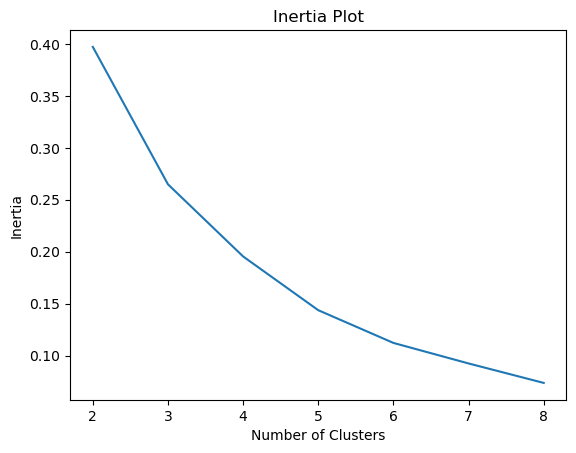

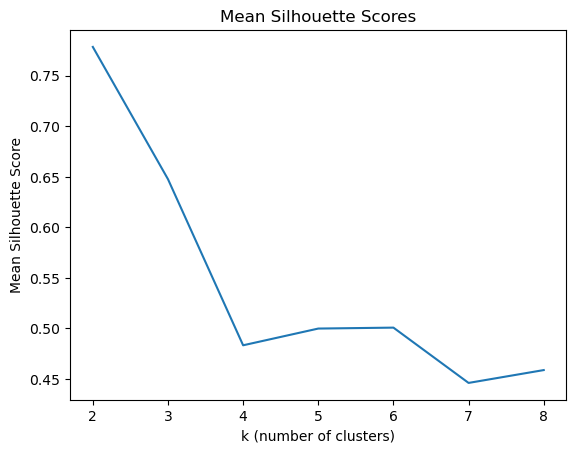

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


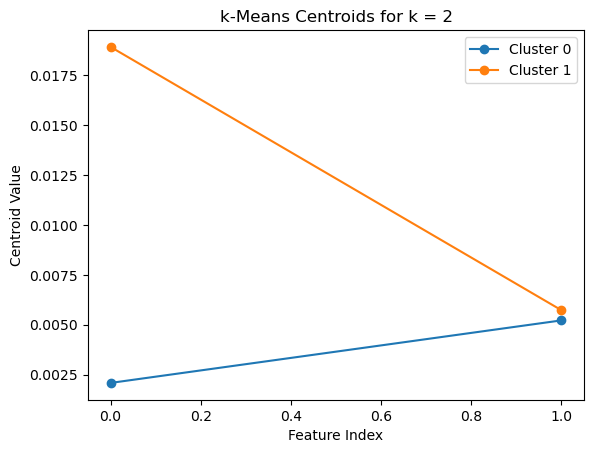

[[0.00208584 0.00521964]
 [0.01892104 0.00572732]]


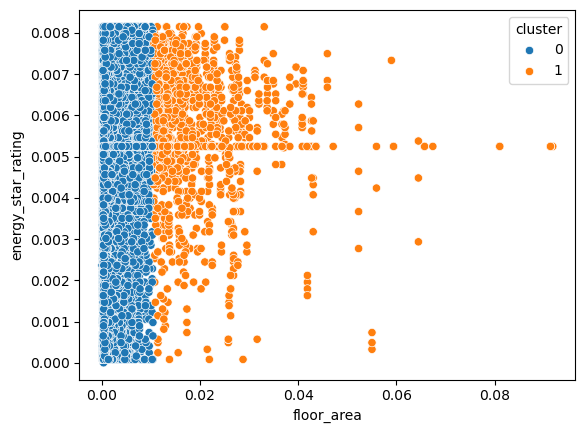

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


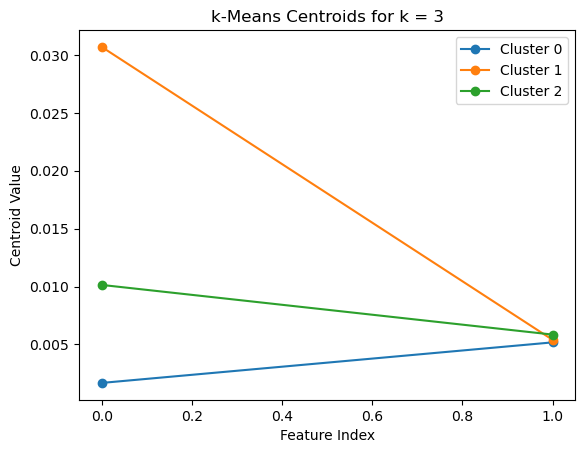

[[0.001673   0.00517497]
 [0.03069131 0.0053932 ]
 [0.01013664 0.00584676]]


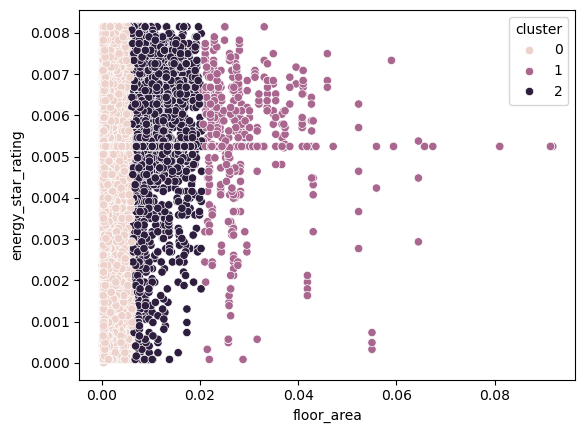

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


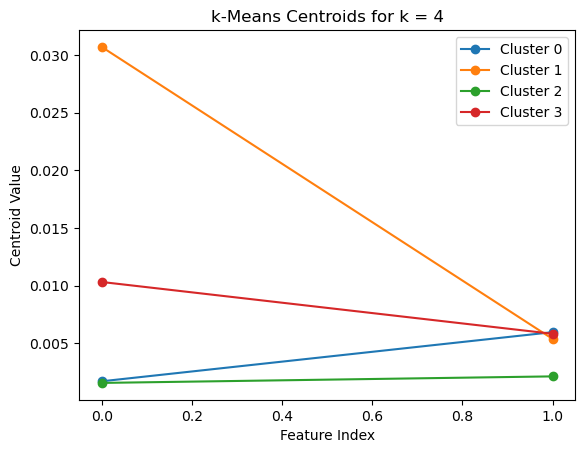

[[0.00172452 0.00598192]
 [0.03069131 0.0053932 ]
 [0.00158358 0.00215018]
 [0.01032791 0.00583948]]


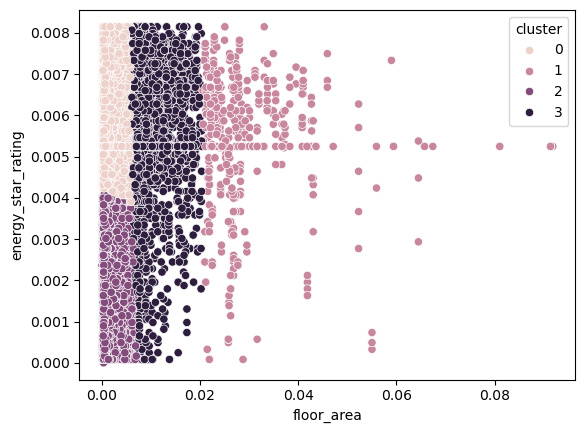

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

RF scores with 2 clusters:
[0.4415580598289707, 0.7000818612650508]

RF scores with 3 clusters:
[0.4097551828112157, 0.7392759848067072, 0.6177766010884672]

RF scores with 4 clusters:
[0.37052707475299285, 0.7766754732096572, 0.5672905737141838, 0.6415697764438064]

RF scores with 5 clusters:
[0.3884703265782873, 0.6320006420065989, 0.5093698111441616, 0.5492409547847263, 0.3903306247440582]

RF scores with 6 clusters:
[0.5251486514108428, 0.2959487513871556, 0.7475569496350393, 0.5054003071508784, 0.9008529433872591, 0.279219562230575]

RF scores with 7 clusters:
[0.46444200334020025, 0.7585753243470111, 0.5193578221590955, 0.5623481000643655, 0.6761301994837754, 0.3116398183932192, 0.5325100373405274]

RF scores with 8 clusters:
[0.2821330049084899, 0.7334632002760267, 0.6514460732962254, -0.21129707204104764, 0.5455997538398483, 0.5736673036902299, 0.556589591178622, 0.4572283118680177]



In [13]:
### KMEANS FOR COMMERCIAL ###

plot_inertia_and_sil(com_train_df)

# Dictionary with num_clusters as keys and rf_score lists as values
rf_scores_com = dict()

# Run kmeans and random forest
for k in range(2,9):
    kmeans_model, com_df_clus = k_means(k,com_train_df)
    rf_scores = rf_cluster(com_df_clus,k)
    rf_scores_com[k] = rf_scores

    # Plot centroids
    if (k in [2,3,4]):
        plot_centroids(kmeans_model.cluster_centers_)
        print(kmeans_model.cluster_centers_)

        # Plot floor area and energy star rating with cluster hue
        sns.scatterplot(com_df_clus,x='floor_area',y='energy_star_rating',hue='cluster')
        plt.show()
    
for k in rf_scores_com.keys():
    print("RF scores with", k, "clusters:")
    print(rf_scores_com[k])
    print()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


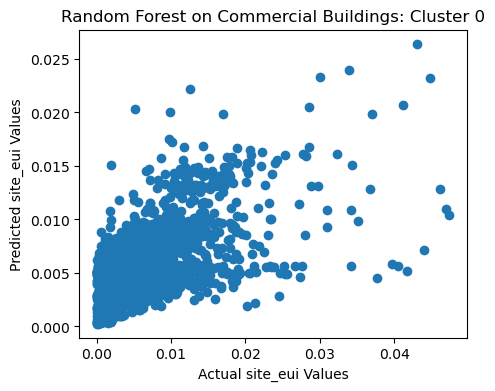

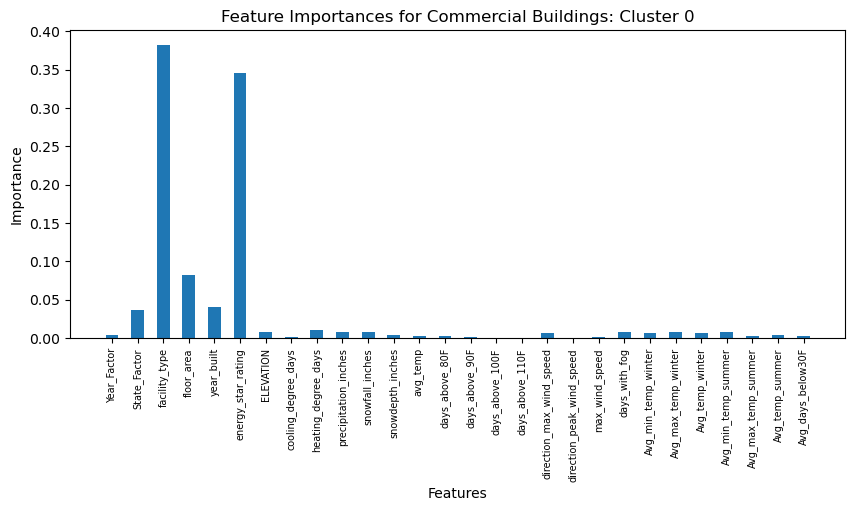

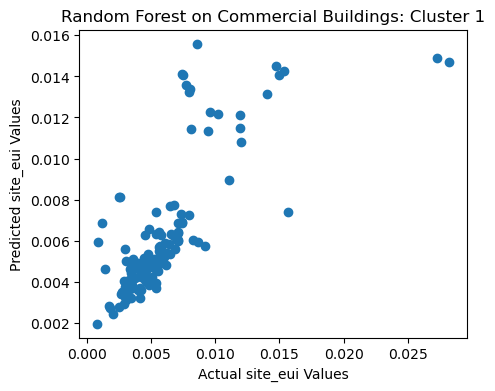

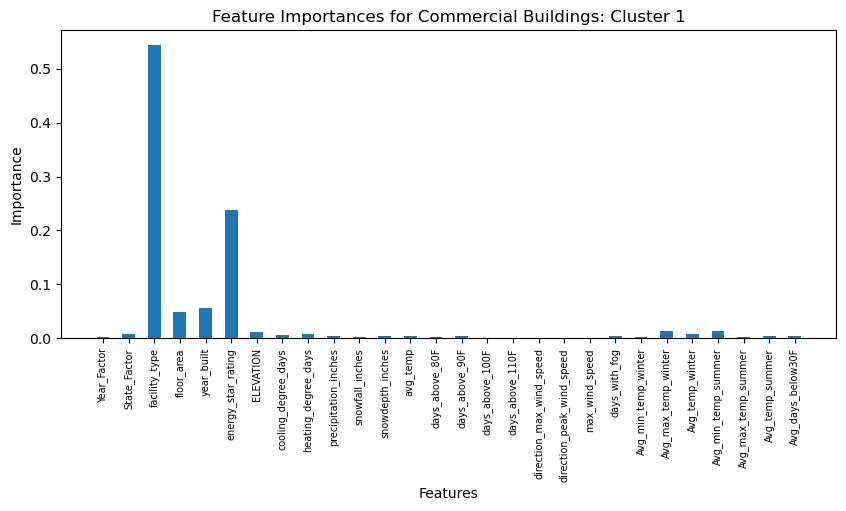

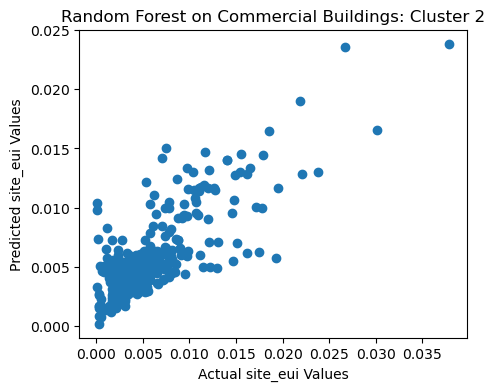

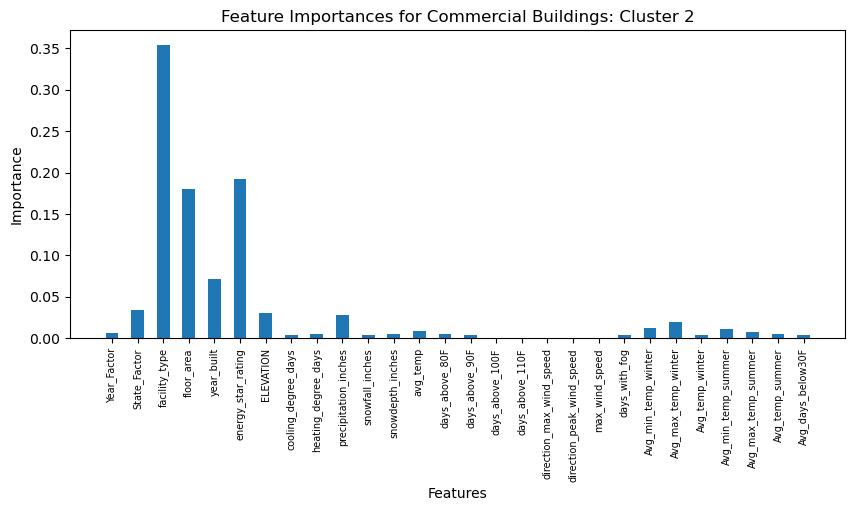

Scores: [0.4637455615208521, 0.5688389192066039, 0.6548916410374988]


In [14]:
### RANDOM FOREST ON COMMERCIAL WITH 3 CLUSTERS ###

# Fit k-means with k = 3
kmeans3, com_df_clus = k_means(3,com_train_df) 
rf_scores = []
y_test_total = []
y_pred_total = []

# Run random forest on each cluster
for i in range(3):
    # Isolate current cluster
    cluster_df = com_df_clus.loc[com_df_clus['cluster'] == i]
    y = np.array(cluster_df['site_eui']).reshape(-1,1)
    X = cluster_df.drop(columns=['site_eui', 'id', 'cluster'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Run random forest
    rf = RandomForestRegressor(n_estimators=40, max_depth=8)
    rf.fit(X_train, y_train.ravel())
    y_pred = rf.predict(X_test)
    score = rf.score(X_test, y_test)
    rf_scores.append(score)

    y_test_total.extend(y_test.ravel())
    y_pred_total.extend(y_pred)

    # Plot Results
    plt.figure(figsize=(5,4))
    plt.scatter(y_test,y_pred)
    plt.title("Random Forest on Commercial Buildings: Cluster " + str(i))
    plt.xlabel("Actual site_eui Values")
    plt.ylabel("Predicted site_eui Values")

    # Plot Feature Importances
    plt.figure(figsize=(10,4))
    features = np.array(X.columns)
    plt.bar(features, rf.feature_importances_, width=0.5)
    plt.xticks(fontsize=7, rotation=90)
    plt.title("Feature Importances for Commercial Buildings: Cluster " + str(i))
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()

print("Scores:", rf_scores)

Total score: 0.48235332348401194


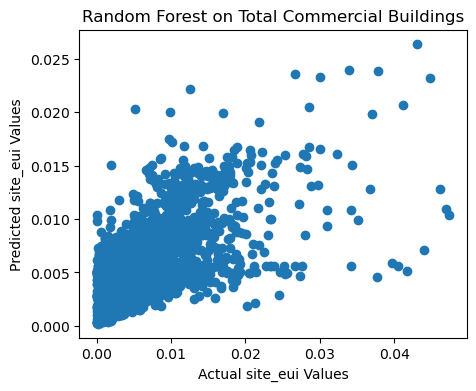

In [15]:
### TOTAL COMMERCIAL RESULTS ###

# Plot Results
plt.figure(figsize=(5,4))
plt.scatter(y_test_total,y_pred_total)
plt.title("Random Forest on Total Commercial Buildings")
plt.xlabel("Actual site_eui Values")
plt.ylabel("Predicted site_eui Values")

total_score = metrics.r2_score(y_test_total, y_pred_total)
print("Total score:", total_score)

In [16]:
### SAVE TOTAL RESIDENTIAL DATA TO CSV ###

# Get dataframe
total_com_df = pd.DataFrame()
total_com_df["actual_site_eui"] = y_test_total
total_com_df["predict_site_eui"] = y_pred_total

# Save to CSV
total_com_df.to_csv("combined_commercial_results.csv",index=False)

total_com_df.head()

,actual_site_eui,predict_site_eui
0,0.018763,0.006744
1,0.004740,0.004818
2,0.003619,0.002057
3,0.004799,0.004247
4,0.002400,0.002845


/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

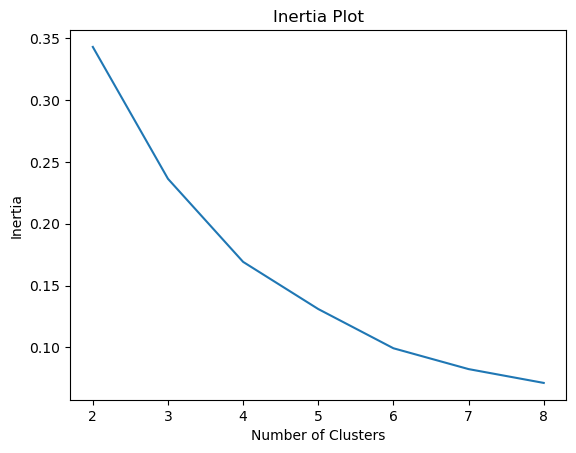

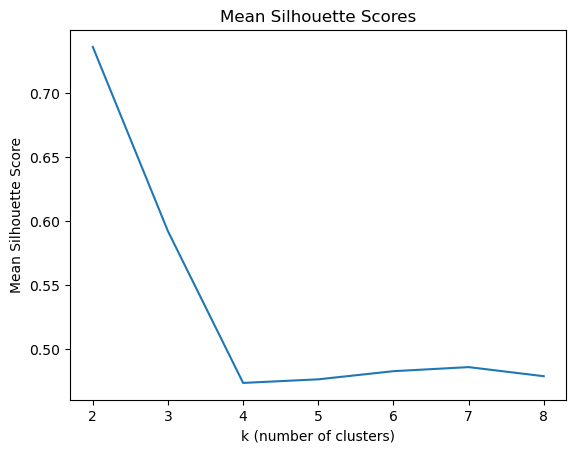

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


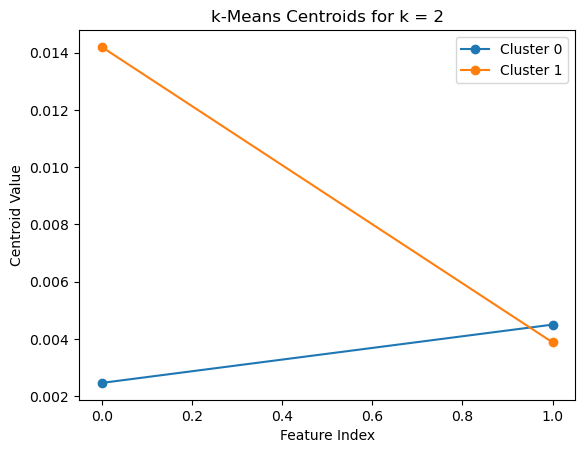

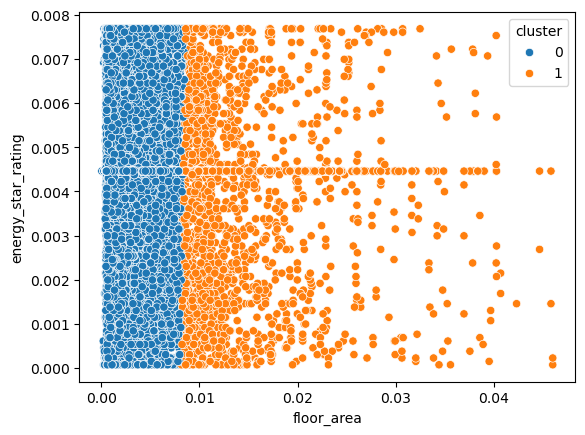

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


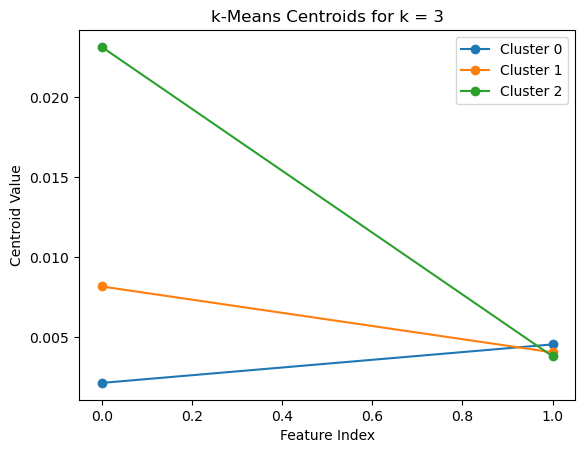

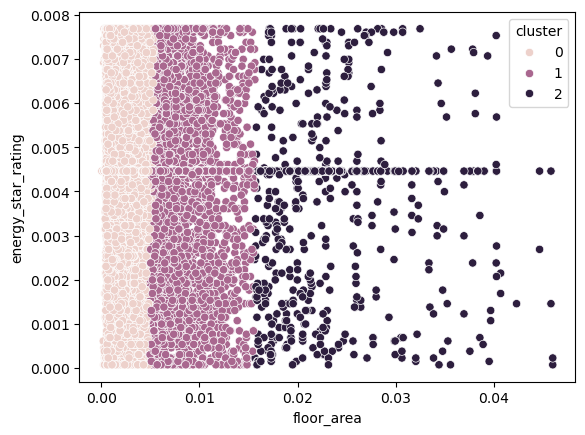

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


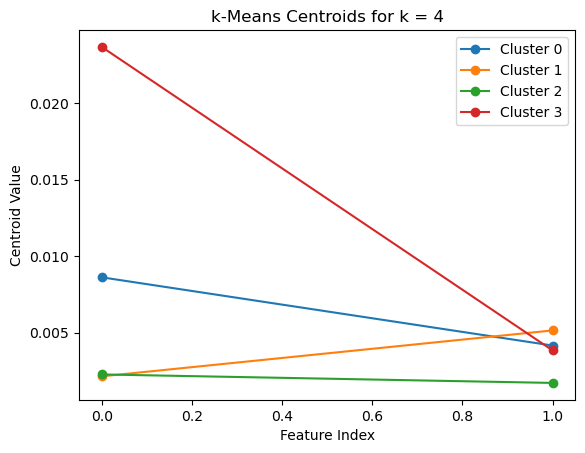

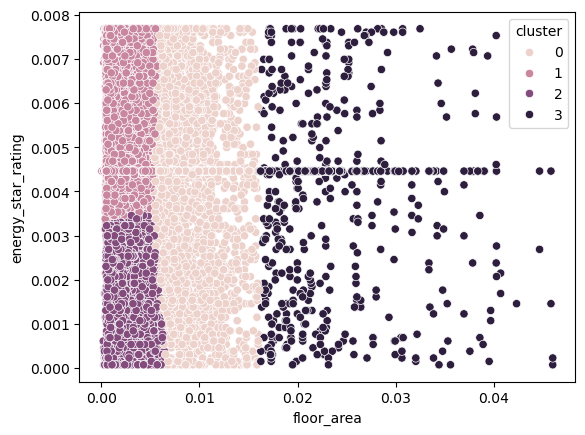

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

RF scores with 2 clusters:
[0.35007004175949485, 0.30845437719150604]

RF scores with 3 clusters:
[0.35049753388886296, 0.417192259425743, 0.31536764821213126]

RF scores with 4 clusters:
[0.3097588525755597, 0.2280272704768781, 0.3641489625807268, 0.44239425110329667]

RF scores with 5 clusters:
[0.2749448142014619, 0.19299997384229062, 0.29550707395349585, 0.2785182119087948, 0.3355234110455746]

RF scores with 6 clusters:
[0.3173854564515276, 0.1672369880829837, 0.325886668700094, 0.24777151384300922, 0.3279133137014243, 0.11142488544907636]

RF scores with 7 clusters:
[0.396620815451422, 0.17335919539937217, 0.46807044243984175, 0.3695184253359637, 0.2311539060083353, 0.439621162303519, 0.17848804731875512]

RF scores with 8 clusters:
[0.5023001462716032, 0.19016047210280895, 0.3209087754537693, 0.194480928311636, 0.3531579887763573, 0.38622582450509535, 0.19043798980801174, 0.44959817246094214]



In [17]:
### KMEANS FOR RESIDENTIAL ###

plot_inertia_and_sil(res_train_df)

# Dictionary with num_clusters as keys and rf_score lists as values
rf_scores_res = dict()

# Run kmeans and random forest
for k in range(2,9):
    kmeans_model, res_df_clus = k_means(k,res_train_df)
    rf_scores = rf_cluster(res_df_clus,k)
    rf_scores_res[k] = rf_scores

    # Plot centroids
    if (k in [2,3,4]):
        plot_centroids(kmeans_model.cluster_centers_)

        # Plot floor area and energy star rating with cluster hue
        sns.scatterplot(res_df_clus,x='floor_area',y='energy_star_rating',hue='cluster')
        plt.show()

for k in rf_scores_res.keys():
    print("RF scores with", k, "clusters:")
    print(rf_scores_res[k])
    print()